Analyzing serial neurogym results

In [1]:
#!/usr/bin/env python
# coding: utf-8
# system
import os
import sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')
from pathlib import Path
import json
# tools
import time
import itertools
from collections import defaultdict
# computation
import math
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
# tasks
import gym
import neurogym as ngym
from neurogym.wrappers import ScheduleEnvs
from neurogym.utils.scheduler import RandomSchedule
# models
# from model_dev import RNN_MD
# from model_dev import serial_RNN_MD as RNN_MD
# from utils import get_full_performance
# visualization
import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
# mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm, trange

In [2]:
exp_name= 'order_order_order_nogates'
print('current folder: ', os.getcwd())
data_folder = './../files/'+exp_name+'/'
filenames = os.listdir(data_folder)
log_files3 = [logfile for logfile in filenames if logfile.__contains__('testing_log')]
config_files3 = [logfile for logfile in filenames if logfile.__contains__('config')]
# print('config files: ', config_files)
print('testing_logs :', log_files3)

current folder:  /home/ahummos/code/PFC_MD_Modeling/CL_neurogym/analysis
testing_logs : ['testing_log_10_-1.0_2000.0_gaus_cut_tc_mul_nog.npy', 'testing_log_11_-1.0_2000.0_gaus_cut_tc_mul_nog.npy', 'testing_log_12_-1.0_2000.0_gaus_cut_tc_mul_nog.npy', 'testing_log_13_-1.0_2000.0_gaus_cut_tc_mul_nog.npy', 'testing_log_14_-1.0_2000.0_gaus_cut_tc_mul_nog.npy', 'testing_log_15_-1.0_2000.0_gaus_cut_tc_mul_nog.npy', 'testing_log_16_-1.0_2000.0_gaus_cut_tc_mul_nog.npy', 'testing_log_17_-1.0_2000.0_gaus_cut_tc_mul_nog.npy', 'testing_log_18_-1.0_2000.0_gaus_cut_tc_mul_nog.npy', 'testing_log_19_-1.0_2000.0_gaus_cut_tc_mul_nog.npy', 'testing_log_3_-1.0_2000.0_gaus_cut_tc_mul_nog.npy', 'testing_log_4_-1.0_2000.0_gaus_cut_tc_mul_nog.npy', 'testing_log_5_-1.0_2000.0_gaus_cut_tc_mul_nog.npy', 'testing_log_6_-1.0_2000.0_gaus_cut_tc_mul_nog.npy', 'testing_log_7_-1.0_2000.0_gaus_cut_tc_mul_nog.npy', 'testing_log_8_-1.0_2000.0_gaus_cut_tc_mul_nog.npy', 'testing_log_9_-1.0_2000.0_gaus_cut_tc_mul_nog.npy']


In [3]:
exp_name= 'order_order_order'
print('current folder: ', os.getcwd())
data_folder = './../files/'+exp_name+'/'
filenames = os.listdir(data_folder)
log_files = [logfile for logfile in filenames if logfile.__contains__('testing_log')]
config_files = [logfile for logfile in filenames if logfile.__contains__('config')]
# print('config files: ', config_files)

log_files1 = [logfile for logfile in log_files if not logfile.__contains__('SecRound')]
log_files2 = [logfile for logfile in log_files if logfile.__contains__('SecRound')]
config_files1 = [logfile for logfile in config_files if not logfile.__contains__('SecRound')]
config_files2 = [logfile for logfile in config_files if logfile.__contains__('SecRound')]
print('testing_logs :', log_files2)

current folder:  /home/ahummos/code/PFC_MD_Modeling/CL_neurogym/analysis
testing_logs : ['testing_log_SecRound_10_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'testing_log_SecRound_11_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'testing_log_SecRound_12_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'testing_log_SecRound_13_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'testing_log_SecRound_14_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'testing_log_SecRound_15_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'testing_log_SecRound_16_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'testing_log_SecRound_17_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'testing_log_SecRound_18_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'testing_log_SecRound_19_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'testing_log_SecRound_3_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'testing_log_SecRound_4_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'testing_log_SecRound_5_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'testing_log_SecRound_6_-1.0_2000.0_gaus_cut_tc_mul_gates.npy', 'test

In [6]:
lfiles = log_files1
logs = []
for fi, fn in enumerate(lfiles):
    logs.append(np.load(f'./../files/{exp_name}/' + fn, allow_pickle=True).item())


/tmp/ipykernel_46169/1651177177.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=ax.set_xticklabels( ['', 'random gates','', 'Corr gates', '','No gates'], rotation=0 )


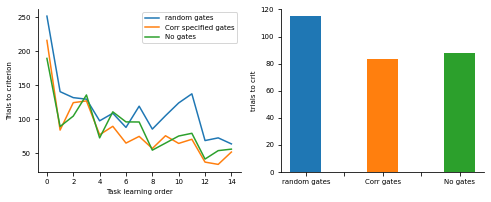

In [23]:
# Clean up and make into a function
def get_ttc_new_tasks(logs):
    ttc_new_tasks = []

    for log in logs:
        already_seen = []
        new_task_tc = []
        for ti, id in enumerate(log.switch_task_id):
            if id not in already_seen:
                new_task_tc.append(log.switch_trialxxbatch[ti+1]-log.switch_trialxxbatch[ti])
                already_seen.append(id)
                # print('task ID: ', id, '  tc:  ', new_task_tc[-1])

        ttc_new_tasks.append(new_task_tc)
    return(np.stack(ttc_new_tasks))
exp_name= 'order_order_order'
lfiles = log_files1
logs = []
for fi, fn in enumerate(lfiles):
    logs.append(np.load(f'./../files/{exp_name}/' + fn, allow_pickle=True).item())

ttc_new_1st = get_ttc_new_tasks(logs)

lfiles = log_files2
logs = []
for fi, fn in enumerate(lfiles):
    logs.append(np.load(f'./../files/{exp_name}/' + fn, allow_pickle=True).item())

ttc_new_2nd = get_ttc_new_tasks(logs)

exp_name= 'order_order_order_nogates'
lfiles = log_files3
logs = []
for fi, fn in enumerate(lfiles):
    logs.append(np.load(f'./../files/{exp_name}/' + fn, allow_pickle=True).item())

ttc_new_3rd = get_ttc_new_tasks(logs)


fig, axes = plt.subplots(1,2, figsize=([8,3]))
color1= 'tab:blue'
color2= 'tab:orange'
color3= 'tab:green'
m1 = ttc_new_1st.mean(0)
s1 = ttc_new_1st.std(0)
m2 = ttc_new_2nd.mean(0)
s2 = ttc_new_2nd.std(0)
m3 = ttc_new_3rd.mean(0)
s3 = ttc_new_3rd.std(0)
ax =axes[0]
ax.plot(m1, label= 'random gates', color= color1)
# ax.fill_between(range(len(m1)), m1-s1, m1+s1, alpha=0.3, color= color1)
ax.plot(m2, label='Corr specified gates', color= color2)
# ax.fill_between(range(len(m2)), m2-s2, m2+s2, alpha=0.3, color= color2)
ax.plot(m3, label='No gates', color= color3)
ax.legend()
ax.set_xlabel('Task learning order')
ax.set_ylabel('Trials to criterion')

ax =axes[1]

ax.bar(range(5), [m1.mean(),0., m2.mean(), 0.,m3.mean()], color= [ color1, 'b', color2, 'b', color3])
# ax.errorbar(range(5),[m1.mean(),0., m2.mean(), 0.,m3.mean()], [m1.std(),0., m2.std(), 0.,m3.std()])
_=ax.set_xticklabels( ['', 'random gates','', 'Corr gates', '','No gates'], rotation=0 )
ax.set_ylabel('trials to crit')
plt.savefig('trials_to_crit_new_tasks_corr_gates',dpi=300)

/tmp/ipykernel_46169/3269487476.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=ax.set_xticklabels( ['', 'rnd gates','', 'Corr gates', '','No gates'], rotation=0 )


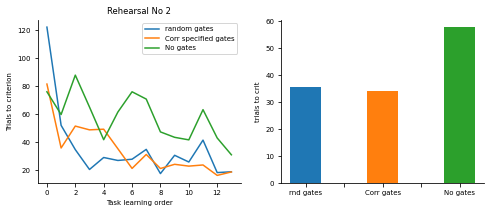

In [21]:
# Lok at rehearsals

def get_ttc_rehearsals(logs, rehearsal_no):
    rehearsal_data=[]
    for log in logs:
        tstamps = log.switch_trialxxbatch + [log.total_batches]

        counts = np.zeros(15)
        times_seen =[]
        ttcs = []
        for ti, id in enumerate(log.switch_task_id):
            times_seen.append(counts[id])
            ttcs.append(tstamps[ti+1]- tstamps[ti])
            counts[id] +=1
        rehearsal_data.append(np.array(ttcs)[np.array(times_seen)==rehearsal_no])
    return(np.stack(rehearsal_data))
# rd = get_ttc_rehearsals(logs, 1)

rehearsal_no = 2

exp_name= 'order_order_order'
lfiles = log_files1
logs = []
for fi, fn in enumerate(lfiles):
    logs.append(np.load(f'./../files/{exp_name}/' + fn, allow_pickle=True).item())

ttc_reh_1st = get_ttc_rehearsals(logs, rehearsal_no)

lfiles = log_files2
logs = []
for fi, fn in enumerate(lfiles):
    logs.append(np.load(f'./../files/{exp_name}/' + fn, allow_pickle=True).item())

ttc_reh_2nd = get_ttc_rehearsals(logs, rehearsal_no)

exp_name= 'order_order_order_nogates'
lfiles = log_files3
logs = []
for fi, fn in enumerate(lfiles):
    logs.append(np.load(f'./../files/{exp_name}/' + fn, allow_pickle=True).item())
exp_name= 'order_order_order'

ttc_reh_nogates = get_ttc_rehearsals(logs, rehearsal_no)


fig, axes = plt.subplots(1,2, figsize=([8,3]))
color1= 'tab:blue'
color2= 'tab:orange'
color3= 'tab:green'
m1 = ttc_reh_1st.mean(0)
s1 = ttc_reh_1st.std(0)
m2 = ttc_reh_2nd.mean(0)
s2 = ttc_reh_2nd.std(0)
m3 = ttc_reh_nogates.mean(0)
s3 = ttc_reh_nogates.std(0)
ax =axes[0]
ax.plot(m1, label= 'random gates', color= color1)
# ax.fill_between(range(len(m1)), m1-s1, m1+s1, alpha=0.3, color= color1)
ax.plot(m2, label='Corr specified gates', color= color2)
# ax.fill_between(range(len(m2)), m2-s2, m2+s2, alpha=0.3, color= color2)
ax.plot(m3, label='No gates', color= color3)
ax.set_title(f'Rehearsal No {rehearsal_no}')
ax.legend()
ax.set_xlabel('Task learning order')
ax.set_ylabel('Trials to criterion')

ax =axes[1]

ax.bar(range(5), [m1.mean(),0., m2.mean(), 0.,m3.mean()], color= [ color1, 'b', color2, 'b', color3])
# ax.errorbar(range(5),[m1.mean(),0., m2.mean(), 0.,m3.mean()], [m1.std(),0., m2.std(), 0.,m3.std()])
_=ax.set_xticklabels( ['', 'rnd gates','', 'Corr gates', '','No gates'], rotation=0 )
ax.set_ylabel('trials to crit')

plt.savefig(f'trials_to_crit_{rehearsal_no}th_rehearsal_tasks_corr_gates.jpg',dpi=300)

No handles with labels found to put in legend.


Text(0, 0.5, 'Trials to criterion')

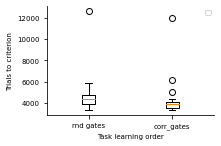

In [70]:
exp_name= 'order_order_order'
lfiles = log_files1
logs = []
for fi, fn in enumerate(lfiles):
    logs.append(np.load(f'./../files/{exp_name}/' + fn, allow_pickle=True).item())

random_gates_totals = [log.total_batches for log in logs]
random_gates_totals_m = np.mean(random_gates_totals)

lfiles = log_files2
logs = []
for fi, fn in enumerate(lfiles):
    logs.append(np.load(f'./../files/{exp_name}/' + fn, allow_pickle=True).item())

corr_gates_totals = [log.total_batches for log in logs]

fig, ax = plt.subplots(1,1, figsize=([3,2]))

color1= 'tab:blue'
color2= 'tab:orange'
# ax.boxplot(['rnd gates', 'corr_gates'], [np.mean(r) for r in [random_gates_totals, corr_gates_totals]], color= [color1, color2])
# ax.errorbar(range(5),[m1.mean(),0., m2.mean(), 0.,m3.mean()], [m1.std(),0., m2.std(), 0.,m3.std()])
ax.boxplot([random_gates_totals, corr_gates_totals], labels=['rnd gates', 'corr_gates'])
ax.legend()
ax.set_xlabel('Task learning order')
ax.set_ylabel('Trials to criterion')


[4791,
 4221,
 4627,
 3703,
 4689,
 4144,
 4940,
 12619,
 3900,
 3367,
 4344,
 3735,
 5851,
 4752,
 3628,
 5512,
 3971]

In [31]:
# Compile ALL rehearsals

def get_rehearsal_stamps(log_files, exp_name, rehearsal_no=None):
    ''' if rehearsal_no is None do not filter and return all rehearsals'''
    rehearsal_data=[]
    data = []
    logs = []
    for fn in log_files:
        logs.append(np.load(fn, allow_pickle=True).item())
    for log in logs:
        tstamps = log.switch_trialxxbatch + [log.total_batches]

        counts = np.zeros(15)
        times_seen =[]
        ttcs = []
        for ti, id in enumerate(log.switch_task_id):
            times_seen.append(counts[id])
            ttcs.append(tstamps[ti+1]- tstamps[ti])
            counts[id] +=1
        rehearsal_data.append(np.array(ttcs)[np.array(times_seen)==rehearsal_no])
        stamp_tid_no_rehearsals = np.array([log.switch_trialxxbatch,log.switch_task_id , ttcs, times_seen])
        data.append(stamp_tid_no_rehearsals)
    return(np.stack(data))

exp_name= 'order_order_order'
lfiles = log_files1.copy()
for fi, fn in enumerate(lfiles):
    lfiles[fi] = f'./../files/{exp_name}/' + fn 
stamp_tid_no_rehearsals = get_rehearsal_stamps(lfiles, 'order_order_order', None)

    


In [35]:
print('shape: ', stamp_tid_no_rehearsals.shape) #(17, 4, 134)


shape:  (17, 4, 134)


In [36]:
exp_name= 'order_order_order'
lfiles = log_files1
logs = []
for fi, fn in enumerate(lfiles):
    logs.append(np.load(f'./../files/{exp_name}/' + fn, allow_pickle=True).item())


In [49]:
log_id = 0
print('no of time stamps: ', len(logs[log_id].stamps))
stamp_tid_no_rehearsals[log_id][0]


no of time stamps:  497


array([   0.,  172.,  338.,  366.,  470.,  507.,  529.,  547.,  559.,
        784.,  834.,  889.,  912., 1059., 1191., 1211., 1240., 1252.,
       1278., 1352., 1568., 1597., 1643., 1657., 1751., 1790., 1849.,
       1917., 1934., 1960., 1972., 1985., 2006., 2037., 2062., 2222.,
       2256., 2298., 2312., 2345., 2378., 2397., 2428., 2464., 2482.,
       2501., 2518., 2529., 2543., 2561., 2574., 2605., 2618., 2630.,
       2744., 2763., 2785., 2797., 2809., 2827., 2841., 2862., 2875.,
       2886., 2922., 3089., 3137., 3195., 3207., 3266., 3290., 3314.,
       3344., 3442., 3454., 3491., 3519., 3725., 3742., 3756., 3768.,
       3782., 3800., 3823., 3844., 3875., 3887., 3928., 3942., 4018.,
       4044., 4065., 4079., 4091., 4104., 4118., 4140., 4156., 4177.,
       4189., 4211., 4224., 4269., 4285., 4308., 4327., 4350., 4362.,
       4376., 4389., 4402., 4417., 4429., 4441., 4468., 4480., 4510.,
       4522., 4533., 4579., 4596., 4608., 4619., 4637., 4649., 4667.,
       4678., 4691.,

In [57]:
#Get time stamps of new trials:
print('time stamps of new tasks: \n', stamp_tid_no_rehearsals[log_id][0][stamp_tid_no_rehearsals[log_id][3]==0])
print('No of trials for new tasks: \n', stamp_tid_no_rehearsals[log_id][2][stamp_tid_no_rehearsals[log_id][3]==0])
print('time stamps in testing log: ', logs[log_id].stamps)

time stamps of new tasks: 
 [   0.  172.  470.  559. 1059. 1352. 1849. 2062. 2464. 2630. 2922. 3519.
 4018. 4285. 4533.]
No of trials for new tasks: 
 [172. 166.  37. 225. 132. 216.  68. 160.  18. 114. 167. 206.  26.  23.
  46.]
time stamps in testing log:  [9, 19, 29, 39, 49, 59, 69, 79, 89, 99, 109, 119, 129, 139, 149, 159, 169, 179, 189, 199, 209, 219, 229, 239, 249, 259, 269, 279, 289, 299, 309, 319, 329, 339, 349, 359, 369, 379, 389, 399, 409, 419, 429, 439, 449, 459, 469, 479, 489, 499, 509, 519, 529, 529, 539, 549, 559, 559, 569, 579, 589, 599, 609, 619, 629, 639, 649, 659, 669, 679, 689, 699, 709, 719, 729, 739, 749, 759, 769, 779, 789, 799, 809, 819, 829, 839, 849, 859, 869, 879, 889, 889, 899, 909, 919, 929, 939, 949, 959, 969, 979, 989, 999, 1009, 1019, 1029, 1039, 1049, 1059, 1059, 1069, 1079, 1089, 1099, 1109, 1119, 1129, 1139, 1149, 1159, 1169, 1179, 1189, 1199, 1209, 1219, 1229, 1239, 1249, 1259, 1269, 1279, 1289, 1299, 1309, 1319, 1329, 1339, 1349, 1359, 1369, 1379, 138

Now the issue is how to get performance data for these when testing is at 0.1 Hz?.... 

In [61]:
new_task_s = 172
new_task_s_test_u = np.argmax((np.array(logs[log_id].stamps) > new_task_s).astype(float)) # gives the index location of the next higher time stamp. 
new_task_s_test_l = new_task_s_test_u -1
new_task_e = new_task_s + 

17

Text(0.5, 1.0, '5th rehearsal')

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


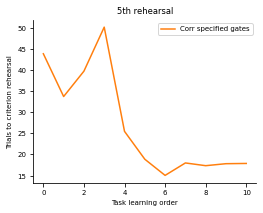

In [8]:

exp_name= 'order_order_order'
lfiles = log_files1
logs = []
for fi, fn in enumerate(lfiles):
    logs.append(np.load(f'./../files/{exp_name}/' + fn, allow_pickle=True).item())

rehearsal_no = 5
ttc_reh_1st = get_ttc_rehearsals(logs, rehearsal_no)

lfiles = log_files2
logs = []
for fi, fn in enumerate(lfiles):
    logs.append(np.load(f'./../files/{exp_name}/' + fn, allow_pickle=True).item())

ttc_reh_2nd = get_ttc_rehearsals(logs, rehearsal_no)

fig, ax = plt.subplots(1,1, figsize=([4,3]))

color1= 'tab:blue'
color2= 'tab:orange'
m1 = ttc_reh_1st.mean(0)
s1 = ttc_reh_1st.std(0)
m2 = ttc_reh_2nd.mean(0)
s2 = ttc_reh_2nd.std(0)
# ax.plot(m1, label= 'random gates', color= color1)
# ax.fill_between(range(len(m1)), m1-s1, m1+s1, alpha=0.3, color= color1)
ax.plot(m2, label='Corr specified gates', color= color2)
# ax.fill_between(range(len(m2)), m2-s2, m2+s2, alpha=0.3, color= color2)
ax.legend()
ax.set_xlabel('Task learning order')
ax.set_ylabel('Trials to criterion rehearsal')
ax.set_title(f'{rehearsal_no}th rehearsal')


# plt.savefig(f'trials_to_crit_{rehearsal_no}th_rehearsal_tasks_corr_gates',dpi=300)

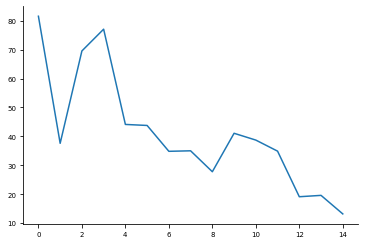

In [99]:

def get_ttc_rehearsals(logs, rehearsal_no):
    rehearsal_data=[]
    for log in logs:
        tstamps = log.switch_trialxxbatch + [log.total_batches]

        counts = np.zeros(15)
        times_seen =[]
        ttcs = []
        for ti, id in enumerate(log.switch_task_id):
            times_seen.append(counts[id])
            ttcs.append(tstamps[ti+1]- tstamps[ti])
            counts[id] +=1
        rehearsal_data.append(np.array(ttcs)[np.array(times_seen)==rehearsal_no])
    return(np.stack(rehearsal_data))
rd = get_ttc_rehearsals(logs, 1)
plt.plot( rd.mean(0))


Ok, now how much do you have to rehearse as a measures of continual learning. 
Gather rehearsals 0 through 15 with task ids and ttc

So I have 15 rehearsals!
Each has an increasing num of tasks. 
for task id, get all the learning trials
take the first one for analsi, butalso need to know the order....
Some compiling by order, 
and some compiling by task. 
